In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-health-and-development-2012-2021/global_health.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/global-health-and-development-2012-2021/global_health.csv')
#print(df.head(20))
print(df.info())
print(df.describe())
print(df.isna().sum())
# normaly should handling missing data before correlation test, however the pearson pairwise deletion
#here have the same result as if imputation mean/median method first(have tested it).
# correlation map
corr_matrix = df.drop(['Country','Country_Code'], axis=1).corr(method='pearson', min_periods=1)
"""
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, 
            annot=True,     
            cmap='coolwarm',
            center=0,       
            vmin=-1, 
            vmax=1,
            square=True)    
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         1880 non-null   object 
 1   Country_Code                    1880 non-null   object 
 2   Year                            1880 non-null   int64  
 3   Fertility_Rate                  1844 non-null   float64
 4   Urban_Population_Percent        1880 non-null   float64
 5   Total_Population                1880 non-null   float64
 6   Water_Access_Percent            1225 non-null   float64
 7   Unemployment_Rate               1740 non-null   float64
 8   Sanitary_Expense_Per_GDP        1834 non-null   float64
 9   Life_Expectancy                 1840 non-null   float64
 10  Life_Expectancy_Female          1840 non-null   float64
 11  Life_Expectancy_Male            1840 non-null   float64
 12  Infant_Deaths                   18

"\nplt.figure(figsize=(20, 16))\nsns.heatmap(corr_matrix, \n            annot=True,     \n            cmap='coolwarm',\n            center=0,       \n            vmin=-1, \n            vmax=1,\n            square=True)    \nplt.title('Pearson Correlation Heatmap')\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n"

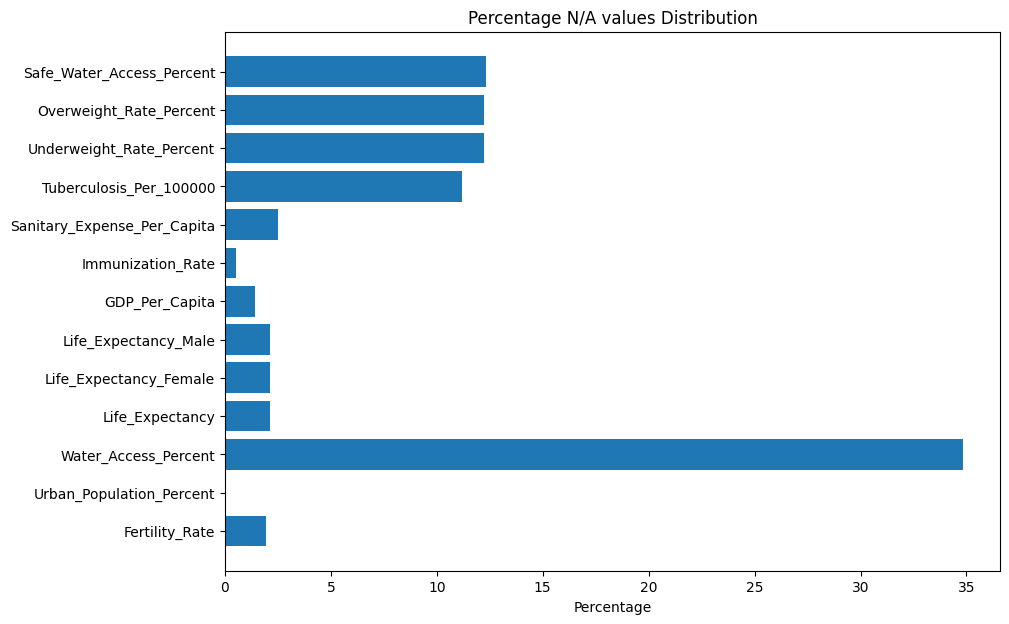

In [3]:
threshold = 0.5
significant_corr = (corr_matrix["Life_Expectancy"].abs() > threshold)
filtered_columns = corr_matrix.columns[significant_corr]

filtered_df = df[filtered_columns]

plt.figure(figsize=(10, 7))
plt.barh(filtered_df.columns, filtered_df.isna().mean()*100)
plt.title('Percentage N/A values Distribution')
plt.xlabel('Percentage')
plt.show()


In [4]:
# For missing data < 15% we use the Simple mean/median imputation.
# For missing data > 30% we remove the affected columns.
choosed_columns = ["Life_Expectancy",
                   "Fertility_Rate",
                   "Urban_Population_Percent", 
                   "Safe_Water_Access_Percent", 
                   "GDP_Per_Capita", 
                   "Immunization_Rate", 
                   "Sanitary_Expense_Per_Capita",
                   "Tuberculosis_Per_100000", 
                   "Underweight_Rate_Percent", 
                   "Overweight_Rate_Percent"]
print(filtered_df[choosed_columns].describe())
clean_df = filtered_df[choosed_columns].fillna(filtered_df.median())
"""
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(choosed_columns):
    sns.histplot(clean_df[col], kde=True, ax=axes[i], label=col)
plt.tight_layout()
plt.show()
"""
combined_df = clean_df.assign(Country=df['Country'])
result = combined_df.groupby('Country')[choosed_columns].mean()
print(result.sort_values(by="Life_Expectancy", ascending=False))

       Life_Expectancy  Fertility_Rate  Urban_Population_Percent  \
count      1840.000000     1844.000000               1880.000000   
mean         71.435155        2.762999                 58.616514   
std           7.836184        1.345580                 23.170964   
min          47.835000        0.808000                 11.194000   
25%          65.367000        1.670000                 40.069000   
50%          72.554000        2.311000                 58.884000   
75%          77.422750        3.645500                 77.633750   
max          84.560000        7.400000                100.000000   

       Safe_Water_Access_Percent  GDP_Per_Capita  Immunization_Rate  \
count                1648.000000     1853.000000        1870.000000   
mean                   81.960376    15919.388028          87.935294   
std                    21.324338    26070.779260          13.140008   
min                    25.610000      216.827417          19.000000   
25%                    65.555000

In [5]:
"""
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
y = pd.DataFrame(df["Life_Expectancy"].fillna(df["Life_Expectancy"].median()))
y = y.values.ravel()
X =  clean_df.drop(["Life_Expectancy"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
tpot = TPOTRegressor(
    generations=5,       # Number of iterations 
    population_size=50,  # Number of models in each generation
    cv=5,                # Cross-validation folds
    random_state=42      # Reproducibility
)

tpot.fit(X_train, y_train)
predictions_noscale = tpot.predict(X_test)
R2_score_W = r2_score(y_test, predictions_noscale)
RMSE_W = np.sqrt(mean_squared_error(y_test, predictions_noscale))
print("R2_score_Without_scaled: ", R2_score_W,
      "RMSE_Without_scaled:", RMSE_W)



pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('tpot', tpot)
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
R2_score = r2_score(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
print("R2_score: ", R2_score,
      "RMSE:", RMSE)
"""

'\nfrom tpot import TPOTRegressor\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler, MinMaxScaler\ny = pd.DataFrame(df["Life_Expectancy"].fillna(df["Life_Expectancy"].median()))\ny = y.values.ravel()\nX =  clean_df.drop(["Life_Expectancy"], axis=1)\nX_train, X_test, y_train, y_test = train_test_split(X, y)\ntpot = TPOTRegressor(\n    generations=5,       # Number of iterations \n    population_size=50,  # Number of models in each generation\n    cv=5,                # Cross-validation folds\n    random_state=42      # Reproducibility\n)\n\ntpot.fit(X_train, y_train)\npredictions_noscale = tpot.predict(X_test)\nR2_score_W = r2_score(y_test, predictions_noscale)\nRMSE_W = np.sqrt(mean_squared_error(y_test, predictions_noscale))\nprint("R2_score_Without_scaled: ", R2_score_W,\n      "RMSE_Without_scaled:", RMSE_W)\n\n\n\npipeline = Pipeline